In [1]:
import os
import csv
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import itertools

from cycler import concat

from numpy.core.numeric import NaN
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split






cwd = os.getcwd()

Part 1: Pre-Processing

In [2]:
#Loading data
vo9 = pd.read_csv(r'/content/vo.9.csv')

In [3]:
#Make a copy
df2 = vo9.copy()

#Focusing specifically on right hand because of cultural norms
df2 = df2[df2["hand"] == "R"]

#Exclusively want Hand to mouth exposures
dfact = df2[(df2["act"]=="Touch")]



#For our frequency column, 0 or 1 given exposure
dfact["freq"] = 0

indexer = (dfact['obj'] == 'Nothing') | (dfact['obj'].astype(str) == 'NaN')
dfact.loc[indexer, 'freq'] = 0
dfact.loc[~indexer, 'freq'] = 1

# dfact = df2[(df2["obj"]!="Nothing") & (~df2["obj"].isna()) & (df2["act"]=="Touch")]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [4]:
dfact[["realtime", "dur", "act", "hh"]]

,realtime,dur,act,hh
1276,2014-06-08 07:23:45.480,23.151746,Touch,10308
1280,2014-06-08 07:23:48.924,3.443816,Touch,10308
1284,2014-06-08 07:24:00.454,11.530159,Touch,10308
1288,2014-06-08 07:24:01.886,1.432384,Touch,10308
1292,2014-06-08 07:24:05.462,3.575857,Touch,10308
...,...,...,...,...
1292284,2016-05-13 13:17:33.496,14.549979,Touch,71103
1292292,2016-05-13 13:17:54.246,16.649970,Touch,71103
1292296,2016-05-13 13:17:54.746,0.499988,Touch,71103
1292300,2016-05-13 13:17:55.266,0.520000,Touch,71103


In [5]:
per_child = {}

hh_list = dfact["hh"].unique()
rounds = dfact["vo.num"].unique()

count = 0

dfact["freq_cumul"] = 0
dfact["freq/hr"] = 0

#go through all the children in hh_list
for child in hh_list:


  #create sub dictionary
  vo_dict = {}


  count2 = 0

  for round in rounds:

    #specify the vo round and child
    df_vo = dfact[(dfact["vo.num"]== str(round)) & (dfact["hh"]== child)]

    #get the cumulative sum of recorded time
    df_vo["record.cumulative"] = df_vo["dur"].shift(1).cumsum().fillna(0)

    #get cumulative sum of exposures
    df_vo["freq_cumul"] = df_vo["freq"].cumsum()

    #Frequency per hour = cumulative number of exposures/total amount of seconds -> converted to hours
    df_vo["freq/hr"] = (df_vo["freq_cumul"].max()/df_vo["record.cumulative"].max())*60*60
    

    #add each of our vo dataframes for each child to this sub dictionary
    vo_dict[count2] = df_vo
    count2 += 1

  #concatenate the dictionary we just created  
  vo_full = pd.concat(vo_dict.values(), ignore_index=True)

  #add it to the larger dictionary
  per_child[count] = vo_full
  count += 1


#combine all into a single df
dfact = pd.concat(per_child.values(), ignore_index=True)


#creating hour running time variable
dfact["recorded_time"] = (pd.to_datetime(dfact["record.cumulative"], unit="s"))

# extracting seconds from time stamp
dfact['recorded_seconds'] = dfact['recorded_time'].dt.second
dfact['recorded_minutes'] =dfact['recorded_time'].dt.minute
dfact['recorded_hours'] =dfact['recorded_time'].dt.hour
dfact["recorded_time"] = dfact['recorded_time'].dt.time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [6]:
dfact["hh"].unique()

array([10308, 11403, 15303, 18402, 18804, 19605, 20801,  2302, 25404,
       26504, 28007, 28604, 28605, 32502, 36701, 38101, 44607, 45201,
       45206,  4801, 49503, 49505, 55705, 58203, 58206, 58703, 58705,
       66506, 71103, 71105])

In [7]:
# array([10308, 11403, 15303, 18402, 18804, 19605, 20801,  2302, 25404,
#        26504, 28007, 28604, 28605, 32502, 36701, 38101, 44607, 45201,
#        45206,  4801, 49503, 49505, 55705, 58203, 58206, 58703, 58705,
#        66506, 71103, 71105])

#to show we have approx 3 hours recorded video per person
dfact[(dfact["hh"] == 18402) & (dfact["vo.num"] == "vo3")][["vo.num","freq", "dur",	"freq_cumul",	"freq/hr",	'record.cumulative',	"recorded_time",	"recorded_seconds",	"recorded_minutes",	"recorded_hours"]]

,vo.num,freq,dur,freq_cumul,freq/hr,record.cumulative,recorded_time,recorded_seconds,recorded_minutes,recorded_hours
15655,vo3,1,1.117463,1,274.173153,0.000000,00:00:00,0,0,0
15656,vo3,1,3.433635,2,274.173153,1.117463,00:00:01.117462,1,0,0
15657,vo3,1,0.893970,3,274.173153,4.551097,00:00:04.551097,4,0,0
15658,vo3,1,6.765727,4,274.173153,5.445067,00:00:05.445067,5,0,0
15659,vo3,1,1.158098,5,274.173153,12.210795,00:00:12.210794,12,0,0
...,...,...,...,...,...,...,...,...,...,...
16972,vo3,1,5.709195,748,274.173153,9859.840053,02:44:19.840053,19,44,2
16973,vo3,1,5.699059,749,274.173153,9865.549248,02:44:25.549248,25,44,2
16974,vo3,1,0.609525,750,274.173153,9871.248307,02:44:31.248307,31,44,2
16975,vo3,1,2.194290,751,274.173153,9871.857832,02:44:31.857832,31,44,2


In [45]:
##so we also need to group by round, not just childz


per_child = {}


hh_list = dfact["hh"].unique()
round = dfact["vo"].unique()
count = 0

dfact["freq_cumul"] = 0
dfact["freq/hr"] = 0

#list of unique hh id's

for child in hh_list:
  #set df
  df = dfact[dfact["hh"]== child]

  #for every round vo1, vo2 vo3

  #add this to our df
  df["record.cumulative"] = df["dur"].shift(1).cumsum().fillna(0)
  per_child[count] = df
  count +=1

  #cumulative frequency of exposure column
  df["freq_cumul"] = df["freq"].cumsum()


  #Frequency per hour = cumulative number of exposures/total amount of seconds -> converted to hours
  df["freq/hr"] = (df["freq_cumul"].max()/df["record.cumulative"].max())*60*60



#combine all into single df
dfact = pd.concat(per_child.values(), ignore_index=True)

#creating hour running time variable
dfact["recorded_time"] = (pd.to_datetime(dfact["record.cumulative"], unit="s")) 

# extracting seconds from time stamp
dfact['recorded_seconds'] = dfact['recorded_time'].dt.second
dfact['recorded_minutes'] =dfact['recorded_time'].dt.minute
dfact['recorded_hours'] =dfact['recorded_time'].dt.hour


# displaying  DataFrame
display(dfact[["recorded_hours", "recorded_minutes", "recorded_time","timestamp" ]])

KeyError: ignored

In [6]:
#Encoding our categorical variables

le = preprocessing.LabelEncoder()
dfact["objenc"] = le.fit_transform(dfact[["obj"]])

dfact["objenc"] = (dfact["objenc"]- np.mean(dfact["objenc"]))/np.std(dfact["objenc"])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
##split dataset use subset function on train, make predictions on test

train, test = train_test_split(dfact, test_size=0.25)

Pt 2 Algorithmic Processing

Storing each Subset

In [30]:
np.mean(train["freq/hr"].unique()), np.median(train["freq/hr"].unique()), np.var(train["freq/hr"]), np.var(train[((train["recorded_minutes"] >= 5) & (train["recorded_minutes"] <=10)) | ((train["recorded_minutes"] >=40) & (train["recorded_minutes"] <= 45)) ]["freq/hr"].unique())



(285.7035546286423, 274.313508300001, 3076.984510965916, 2770.4472405520532)

In [31]:
#these are the times available that you can select
testable_times = [10, 15, 20, 30, 40]
metric_options = ["variance", "mean", "median"]

def subset(time_choice, metric):

  variance = np.var(train["freq/hr"])

  ##create our tuple list of possible times for "realtime.mins" depending on selection
  if time_choice == 10:
    sections = np.linspace(0,60, 13)

  elif time_choice == 20:
    sections = np.linspace(0,60,7)

  elif time_choice == 30 or time_choice == 15:
    sections = np.linspace(0,60,5)

  else:
    sections = np.linspace(0,60,4)

  pair_order_list = itertools.combinations(sections,2)

  combo_list = (list(pair_order_list))

  #remove times that don't make sense (ie if we select 10 mins, we want 2 tuples of 5 mins)
  count = 0
  if time_choice == 15:
    while count < (len(combo_list) -1):
      for item in combo_list:
        if (item[1] - item[0] > time_choice) :
          combo_list.remove(item)
      count +=1


      tuple_list  = (list(itertools.permutations(combo_list, 2)))

    #remove duplicates that are backwards
    tuple_list =  list(set(map(tuple, map(sorted, tuple_list))))

    #filter to get all of the possibilities in a dictionary
    diction = {}
    for i in range(0, len(tuple_list)):
      time_list = []
      new_subset = train[(train["recorded_minutes"] >= tuple_list[i][0][0]) & (train["recorded_minutes"] <= tuple_list[i][0][1])]


      #add column for time
      time_list.append([tuple_list[i][0][0], tuple_list[i][0][1]])
      new_subset["times"] = str(time_list)
      diction[i] = new_subset

  else:
    while count < (len(combo_list) -1):
      for item in combo_list:
        if (item[1] - item[0] > time_choice/2) :
          combo_list.remove(item)
      count +=1
    
  #then, we want to go through permutations of every two of those and do our sampling
    tuple_list  = (list(itertools.permutations(combo_list, 2)))

    if time_choice == 60:
      tuple_list = [(0,60)]

    #remove duplicates that are backwards
    tuple_list =  list(set(map(tuple, map(sorted, tuple_list))))

    #filter to get all of the possibilities in a dictionary
    diction = {}
    for i in range(0, len(tuple_list)):
      time_list = []
      pt1 = train[(train["recorded_minutes"] >= tuple_list[i][0][0]) & (train["recorded_minutes"] <= tuple_list[i][0][1])]
      pt2 = train[(train["recorded_minutes"] >= tuple_list[i][1][0]) & (train["recorded_minutes"] <= tuple_list[i][1][1])]
      new_subset=pd.concat([pt1, pt2], axis = 0)

      #add column for time
      time_list.append([tuple_list[i][0][0], tuple_list[i][0][1], tuple_list[i][1][0], tuple_list[i][1][1]])
      new_subset["times"] = str(time_list)
      diction[i] = new_subset

  if metric == "variance":
      max_var = 0
      best_sub = 0

      #go through all of our possible subsets from previous function and take the avg of freq column
      for item in diction.values():
        var = np.var(item["freq/hr"])

        #Update the subset with the highest variance
        if var > max_var:
          max_var = var
          best_sub_var = item
      new_var = np.var(best_sub_var["freq/hr"].unique())
      print("If you choose to prioritize variance of frequency of exposure" "\n","You should code", time_choice,"minutes of video during these times each hour", best_sub_var["times"].unique(), "\n", "it will capture", ((new_var/variance)*100),"% of the variance of our larger subset")
    
      #return that subset
      return best_sub_var


  elif metric == "mean":
    average = np.mean(train["freq/hr"])

    #starting place to define our best subset
    best_sub = 0

    #storage for averages and the subsets
    avg_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in diction.values():
      ave = np.mean(item["freq/hr"])

      #ignore the nan dataframes
      if math.isnan(ave) == True:
        continue

      #store the dataframe as item, the average is the key in the avg_dict dictionary  
      avg_dict[ave] = item
    
    #take the difference between the actual average of the training set and each individual subset average
    #whichever has the min absolute value difference is the one we want
    best_avg, best_subset_mean = min(avg_dict.items(), key=lambda x: abs(average - x[0]))
    
    new_var = np.var(best_subset_mean["freq/hr"].unique())
    print("If you choose to prioritize mean of frequency of exposure" "\n","You should code", time_choice, "minutes of video during these times each hour", best_subset_mean["times"].unique(), "\n", "it will capture", ((new_var/variance)*100),"% of the variance of our larger subset")
    return best_subset_mean


  elif metric == "median": 
     #overall median we want to be closest to
    median = np.median(train["freq/hr"])

    #starting place to define our best subset
    best_sub = 0

    #storage for medians and the subsets
    median_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in diction.values():
      med = np.median(item["freq/hr"])

      #ignore nan dataframes
      if math.isnan(med) == True:
        continue

      #store the dataframe as item, the median is the key in the med_dict dictionary  
      median_dict[med] = item
    
    #take the difference between the actual median of the training set and each individual subset median
    #whichever has the min absolute value difference is the one we want
    best_med, best_subset_med = min(median_dict.items(), key=lambda x: abs(median - x[0]))
    
    new_var = np.var(best_subset_med["freq/hr"].unique())

    print("If you choose to prioritize median of frequency of exposure" "\n","You should code" , time_choice, "minutes of video during these times each hour", best_subset_med["times"].unique(), "\n", "it will capture", ((new_var/variance)*100),"% of the variance of our larger subset")
    return best_subset_med



#now we just need to pick the best one
specified_dictionary_all = subset(10, "variance")

If you choose to prioritize variance of frequency of exposure
 You should code 10 minutes of video during these times each hour ['[[40.0, 45.0, 45.0, 50.0]]'] 
 it will capture 90.03773761871697 % of the variance of our larger subset


In [ ]:
#sanity check: these should have the same lengths ... and they do!
train[((train["recorded_minutes"] >= 5) & (train["recorded_minutes"] <=10)) | ((train["recorded_minutes"] >=40) & (train["recorded_minutes"] <= 45)) ]

#just make sure ^ was also run on 10 mins
subset(10, "median")

,vo.num,hh,clip,hand,coder,obsnum,cObj,cAct,cFreq,event,...,freq,freq_cumul,freq/hr,record.cumulative,recorded_time,recorded_seconds,recorded_minutes,recorded_hours,objenc,times
40663,vo3,2302,2163,R,n,NaN,StoredWater,Touch,Constant,Feeding,...,1,3118,369.814901,29310.671975,1970-01-01 08:08:30.671975299,30,8,8,1.569289,"[[0.0, 20.0, 40.0, 60.0]]"
31199,vo1,20801,1555,R,r,NaN,Nothing,Touch,Constant,Playing,...,0,18,270.238910,168.239694,1970-01-01 00:02:48.239694499,48,2,0,-0.033526,"[[0.0, 20.0, 40.0, 60.0]]"
113151,vo1,49505,1480,R,a,NaN,Nothing,Touch,Constant,Playing,...,0,184,284.526892,1196.993016,1970-01-01 00:19:56.993015600,56,19,0,-0.033526,"[[0.0, 20.0, 40.0, 60.0]]"
115406,vo1,49505,1492,R,r,NaN,Nothing,Touch,Constant,Playing,...,0,1451,284.526892,11695.610954,1970-01-01 03:14:55.610954200,55,14,3,-0.033526,"[[0.0, 20.0, 40.0, 60.0]]"
37304,vo1,2302,1640,R,a,NaN,Nothing,Touch,Constant,Playing,...,0,1256,369.814901,11688.033223,1970-01-01 03:14:48.033223199,48,14,3,-0.033526,"[[0.0, 20.0, 40.0, 60.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76639,vo1,38101,1173,R,a,NaN,PlantMaterial,Touch,Constant,Playing,...,1,339,365.555073,3539.535296,1970-01-01 00:58:59.535295700,59,58,0,1.035017,"[[0.0, 20.0, 40.0, 60.0]]"
43545,vo1,25404,1038,R,a,NaN,PlantMaterial,Touch,Constant,Feeding,...,1,573,467.182011,3094.304382,1970-01-01 00:51:34.304381900,34,51,0,1.035017,"[[0.0, 20.0, 40.0, 60.0]]"
86910,vo2,44607,1819,R,n,NaN,StoredWater,Touch,Constant,Playing,...,1,1329,286.998951,13448.901485,1970-01-01 03:44:08.901484800,8,44,3,1.569289,"[[0.0, 20.0, 40.0, 60.0]]"
60441,vo1,28604,1035,R,r,NaN,Nothing,Touch,Constant,Playing,...,0,800,261.147127,10642.900950,1970-01-01 02:57:22.900950300,22,57,2,-0.033526,"[[0.0, 20.0, 40.0, 60.0]]"


In [ ]:
#for storing the best of the best, just easier to iterate through
best_subset_dict = {}

best_subset_dict["variance"] = subset(10, "variance")

best_subset_dict["average"] = subset(10, "mean")

best_subset_dict["median"] = subset(10, "median")


If you choose to prioritize variance of frequency of exposure
 You should code 10 minutes of video during these times each hour ['[[10.0, 15.0, 15.0, 20.0]]'] 
 it will capture 27.25900113453684 % of the variance of our larger subset


In [ ]:
#this runs through our function, producing a dictionary that contains all of our subsets in the user specified time frame
# subset_dict = store_subs(train, 40)

#now we process every subset, Return the dataset with the highest R^2 and lowest RMSE
def linear_reg(all_subsets):
  training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()
  model_many = LinearRegression()
  best_sub= 0
  r2_max = 0
  rmse_min = 100

  r2_list = {}
  rmse_list = {}
  count = 0

  

  #go through all of the best subsets we have
  for item in all_subsets.values():
    # if len(item) == 0:
    #   continue
    
    #group them
    grouped = item.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times"])[["realtime.min", "dur", "freq"]].sum().reset_index()
    #run linear regression

    model_many.fit(X = grouped[["actenc", "objenc", "dur"]], y= grouped['freq'])
    y_pred = model_many.predict(training[["actenc", "objenc", "dur"]])
    y_actual = training["freq"]

    #calculate r^2 and rmse for each subset
    r2 = r2_score(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=True)
    # r2_list.append(r2)
    # rmse_list.append(rmse)
    r2_list[count] = r2
    rmse_list[count]= rmse
    count = count+1


    #return the r2 max, r2 min, rmse max, rmse min, and the names of each
  return(r2_list.values(), rmse_list.values(), best_subset_dict.keys())


# lin_best, r2_list, rmse_list, predictions = linear_reg(subset_dict)[0], linear_reg(subset_dict)[1], linear_reg(subset_dict)[2], linear_reg(subset_dict)[3]

best_subset_dict = {}

best_subset_dict["variance"] = subset(10, "variance")
best_subset_dict["average"] = subset(40, "mean")
best_subset_dict["median"] = subset(40, "median")

linear_reg(best_subset_dict)

If you choose to prioritize variance of frequency of exposure
 You should code 10 minutes of video during these times each hour ['[[10.0, 15.0, 15.0, 20.0]]'] 
 it will capture 27.409866431712565 % of the variance of our larger subset
If you choose to prioritize mean of frequency of exposure
 You should code 40 minutes of video during these times each hour ['[[0.0, 20.0, 40.0, 60.0]]'] 
 it will capture 70.06628380775403 % of the variance of our larger subset
If you choose to prioritize median of frequency of exposure
 You should code 40 minutes of video during these times each hour ['[[0.0, 20.0, 40.0, 60.0]]'] 
 it will capture 70.06628380775403 % of the variance of our larger subset


(dict_values([0.423553569288016, 0.4293599866183584, 0.4293599866183584]),
 dict_values([194.15945414844907, 192.20372893383558, 192.20372893383558]),
 dict_keys(['variance', 'average', 'median']))

In [ ]:
best_subset_dict["variance"].groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times"])[["realtime.min", "dur", "freq"]].sum().reset_index()

,hh,vo.num,clip,actenc,objenc,actobjenc,times,realtime.min,dur,freq
0,2302,vo1,1637,0.517648,-1.114714,-0.305995,"[[10.0, 15.0, 15.0, 20.0]]",64,40.512981,6
1,2302,vo1,1637,0.517648,0.202632,0.517599,"[[10.0, 15.0, 15.0, 20.0]]",31,3.565721,3
2,2302,vo1,1637,0.517648,1.602313,1.341194,"[[10.0, 15.0, 15.0, 20.0]]",10,0.975240,1
3,2302,vo1,1638,-1.931600,-1.279382,-2.107608,"[[10.0, 15.0, 15.0, 20.0]]",30,1.930162,2
4,2302,vo1,1638,-1.931600,-1.114714,-2.056133,"[[10.0, 15.0, 15.0, 20.0]]",30,2.600640,2
...,...,...,...,...,...,...,...,...,...,...
2586,71105,vo1,1626,-1.931600,-1.279382,-2.107608,"[[10.0, 15.0, 15.0, 20.0]]",68,91.479854,4
2587,71105,vo1,1626,-1.931600,-1.114714,-2.056133,"[[10.0, 15.0, 15.0, 20.0]]",33,5.549989,2
2588,71105,vo1,1626,0.517648,-1.279382,-0.408944,"[[10.0, 15.0, 15.0, 20.0]]",114,13.829967,7
2589,71105,vo1,1626,0.517648,-1.114714,-0.305995,"[[10.0, 15.0, 15.0, 20.0]]",195,164.999717,13


In [ ]:
best_subset_dict["median"].groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times"])[["realtime.min", "dur", "freq"]].sum().reset_index()

,hh,vo.num,clip,actenc,objenc,actobjenc,times,realtime.min,dur,freq
0,2302,vo1,1635,-1.931600,-1.279382,-2.107608,"[[0.0, 20.0, 40.0, 60.0]]",47,5.469989,1
1,2302,vo1,1635,-1.931600,0.861305,-1.026640,"[[0.0, 20.0, 40.0, 60.0]]",42,2.660001,1
2,2302,vo1,1635,0.517648,-1.279382,-0.408944,"[[0.0, 20.0, 40.0, 60.0]]",528,101.809816,13
3,2302,vo1,1635,0.517648,-1.114714,-0.305995,"[[0.0, 20.0, 40.0, 60.0]]",675,195.159687,18
4,2302,vo1,1635,0.517648,-0.126704,0.311701,"[[0.0, 20.0, 40.0, 60.0]]",5,1.399988,1
...,...,...,...,...,...,...,...,...,...,...
5455,71105,vo1,1626,0.517648,-1.279382,-0.408944,"[[0.0, 20.0, 40.0, 60.0]]",223,9.719978,9
5456,71105,vo1,1626,0.517648,-1.114714,-0.305995,"[[0.0, 20.0, 40.0, 60.0]]",455,242.729553,24
5457,71105,vo1,1626,0.517648,0.202632,0.517599,"[[0.0, 20.0, 40.0, 60.0]]",64,15.069979,3
5458,71105,vo1,1626,0.517648,0.861305,0.929397,"[[0.0, 20.0, 40.0, 60.0]]",12,19.249959,2


In [ ]:

model_many = LinearRegression()
training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()


model_many.fit(X = specified_dictionary_all[["actenc", "objenc", "dur"]], y= specified_dictionary_all['freq'])
y_pred = model_many.predict(training[["actenc", "objenc", "dur"]])
y_actual = training["freq"]

r2_score(y_actual, y_pred)
mean_squared_error(y_actual, y_pred, squared=True)

460.458409228901

AttributeError: ignored

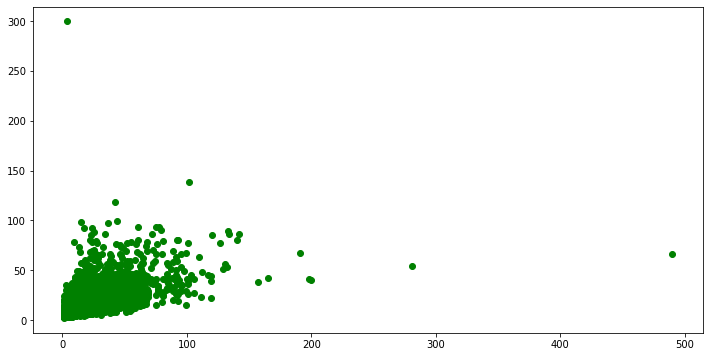

In [ ]:
training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()
x = training["freq"]

plt.figure(figsize=(12, 6))
plt.plot(x, predictions, color='red', label='regression line')     # regression line
plt.scatter(x, predictions, c='green', label='actual values')   # scatter plot showing actual data

Neural Network Predictions: Training

In [ ]:
training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()

In [ ]:
# specified_dictionary_all = subset(10, "variance")
# specified_dictionary_all = subset(10, "mean")
# specified_dictionary_all = subset(10, "median")

#specified_dictionary_all = subset(15, "variance")
# specified_dictionary_all = subset(15, "mean")
#specified_dictionary_all = subset(15, "median")

#specified_dictionary_all = subset(20, "variance")
#specified_dictionary_all = subset(20, "mean")
#specified_dictionary_all = subset(20, "median")

# specified_dictionary_all = subset(30, "variance")
# specified_dictionary_all = subset(30, "mean")
# specified_dictionary_all = subset(30, "median")

# specified_dictionary_all = subset(40, "variance")
# specified_dictionary_all = subset(40, "mean")
specified_dictionary_all = subset(40, "median")



If you choose to prioritize median of frequency of exposure
 You should code 40 minutes of video during these times each hour ['[[0.0, 20.0, 40.0, 60.0]]'] 
 it will capture 70.22782947908766 % of the variance of our larger subset


In [ ]:
#for some reason grouping will not keep duration, time and freq together
#so manually adding it to the subset
freq = specified_dictionary_all.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times"]).sum().reset_index()["freq"].tolist()

best_train=specified_dictionary_all.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times"])[["realtime.min", "dur"]].agg(sum).reset_index()
best_train["freq"] = freq

In [ ]:
nnmod1 = MLPClassifier(hidden_layer_sizes=(100), activation = 'tanh',
                     solver='lbfgs', verbose=1, random_state=1, max_iter = 50, learning_rate = "adaptive")
nnmod1.fit(best_train[["actenc", "objenc", "realtime.min", "dur"]],best_train[["freq"]])
y_pred_train = nnmod1.predict(train[["actenc", "objenc", "realtime.min", "dur"]])

print(accuracy_score(train[["freq"]],y_pred_train))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.8904500630236524


Neural Network Predictions: Test

In [ ]:
testing = test.groupby(["hh", "vo.num", "clip", "actenc", "objenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()

In [ ]:
y_pred_test = nnmod1.predict(testing[["actenc", "objenc", "realtime.min", "dur"]])

print(accuracy_score(testing[["freq"]],y_pred_test))

0.31341534856473346


In [ ]:
train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "realtime.hrs"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()

,hh,vo.num,clip,actenc,objenc,actobjenc,realtime.hrs,realtime.min,dur,freq
0,2302,vo1,1635,-1.931600,-1.279382,-2.107608,8,320,150.179740,10
1,2302,vo1,1635,-1.931600,0.861305,-1.026640,8,69,3.980001,2
2,2302,vo1,1635,0.517648,-1.279382,-0.408944,8,1488,96.219860,42
3,2302,vo1,1635,0.517648,-1.279382,-0.408944,9,14,67.379878,2
4,2302,vo1,1635,0.517648,-1.114714,-0.305995,8,768,134.269768,16
...,...,...,...,...,...,...,...,...,...,...
8070,71105,vo1,1626,0.517648,-1.114714,-0.305995,11,994,474.259120,43
8071,71105,vo1,1626,0.517648,-0.126704,0.311701,11,71,13.030000,2
8072,71105,vo1,1626,0.517648,0.202632,0.517599,11,177,19.389959,6
8073,71105,vo1,1626,0.517648,0.861305,0.929397,11,12,19.249959,2


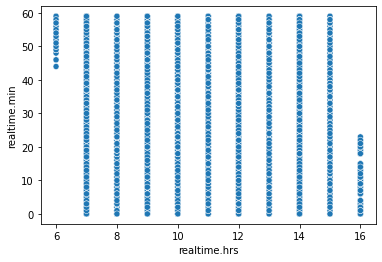

In [ ]:
x = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "realtime.hrs"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()





sns.scatterplot(data = train, x = "realtime.hrs", y= "realtime.min", hue ="freq", legend = None);



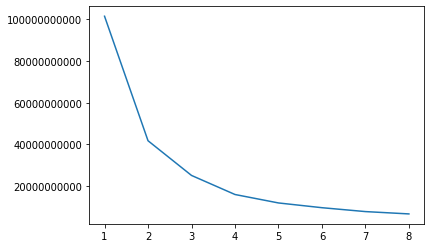

In [ ]:
#suggests there are 3 main clusters
df_clust = train.loc[:, "realtime.hrs":]
yax = []
for i in range(1,9):
  kmeans = KMeans(n_clusters=i, random_state=42)
  kmeans.fit(best_train.loc[:, "realtime.hrs":])
  yax.append(kmeans.inertia_)
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
ax.plot(range(1, 9), yax)
plt.show()

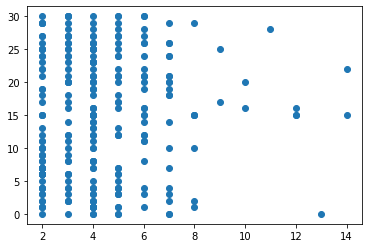

In [ ]:
# plt.scatter(df_clust[df_clust["cluster"]== 2]["freq"], df_clust[df_clust["cluster"]== 2]["realtime.min"])

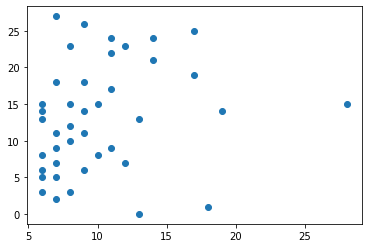

In [ ]:
# plt.scatter(df_clust[df_clust["cluster"]== 1]["freq"], df_clust[df_clust["cluster"]== 1]["realtime.min"])